In [1]:
from collections import defaultdict
import json
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from clip_layerwise_alignment.config import LOCAL_DATA_DIR, LOCAL_MODELS_DIR

In [5]:
def _check_features_matching(data_a, data_b, captions_per_image=5):
    metadata = data_a["metadata"]

    # Verify we have matching filenames for both layers
    assert (
        data_a["metadata"]["filenames"] == data_b["metadata"]["filenames"]
    ), "Metadata ordering mismatch between projected and final features!"

    # Count unique images to sample from
    n_unique_images = len(set(metadata["filenames"]))
    assert n_unique_images * captions_per_image == len(
        metadata["filenames"]
    )  # if not 5 captions per image, the sampling wont work

    return n_unique_images


def _calculate_similarities(
    features_a, features_b, n_unique_images, batch_size=256, captions_per_image=5
):
    images_idx = random.sample(range(n_unique_images), batch_size)
    features_idx = [
        (x * captions_per_image) + random.randint(0, (captions_per_image - 1)) for x in images_idx
    ]

    projected_samples = [features_a[idx] for idx in features_idx]  # Every 5th sample
    projected_batch = torch.stack(projected_samples)
    final_samples = [features_b[idx] for idx in features_idx]
    final_batch = torch.stack(final_samples)

    text_norm = F.normalize(projected_batch, dim=-1)
    image_norm = F.normalize(final_batch, dim=-1)

    logits = (image_norm @ text_norm.T)

    # Get correct and incorrect similarities
    correct_sims = logits.diag().cpu().detach().numpy()
    
    mask = ~torch.eye(len(logits), dtype=bool)
    incorrect_sims = logits[mask].cpu().detach().numpy()

    return correct_sims, incorrect_sims

In [3]:
n_batches = 100
batch_size = 256

results_folder = LOCAL_DATA_DIR / "results" / "flickr30k"

In [6]:
pretrained_similarities = {"correct": [], "incorrect": []}

text_final_data = torch.load(results_folder / f"text_final.pt")
text_final_embeddings = text_final_data["features"]

image_final_data = torch.load(results_folder / f"image_final.pt")
image_final_embeddings = image_final_data["features"]

n_unique_images = _check_features_matching(text_final_data, image_final_data)

for _ in range(n_batches):
    correct_sims, incorrect_sims = _calculate_similarities(
        text_final_embeddings, image_final_embeddings, n_unique_images, batch_size
    )

    pretrained_similarities["correct"].extend(correct_sims)
    pretrained_similarities["incorrect"].extend(incorrect_sims)

# Convert lists to numpy arrays
for encoder in ["text", "image"]:
    for L in range(1, 13):
        pretrained_similarities["correct"] = np.array(pretrained_similarities["correct"])
        pretrained_similarities["incorrect"] = np.array(pretrained_similarities["incorrect"])

In [7]:
similarities = {
    "image": defaultdict(lambda: {"correct": [], "incorrect": []}),
    "text": defaultdict(lambda: {"correct": [], "incorrect": []}),
}

for projected_encoder in ["text", "image"]:
    for L in range(1, 13):
        # Load the required embeddings + metadata
        if projected_encoder == "text":
            projected_data = torch.load(results_folder / f"text_L{L}_image_final_projected.pt")
            projected_features = projected_data["text_embeddings"]

            final_data = torch.load(results_folder / f"image_final.pt")
            final_features = final_data["features"]

        else:  # projected_encoder == "image"
            projected_data = torch.load(results_folder / f"text_final_image_L{L}_projected.pt")
            projected_features = projected_data["image_embeddings"]

            final_data = torch.load(results_folder / f"text_final.pt")
            final_features = final_data["features"]

        n_unique_images = _check_features_matching(final_data, projected_data)

        # Calculate similarities for n_batches random batches
        for _ in range(n_batches):
            correct_sims, incorrect_sims = _calculate_similarities(
                projected_features, final_features, n_unique_images, batch_size
            )

            # Append to lists
            similarities[projected_encoder][L]["correct"].extend(correct_sims)
            similarities[projected_encoder][L]["incorrect"].extend(incorrect_sims)

# Convert lists to numpy arrays
for encoder in ["text", "image"]:
    for L in range(1, 13):
        similarities[encoder][L]["correct"] = np.array(similarities[encoder][L]["correct"])
        similarities[encoder][L]["incorrect"] = np.array(similarities[encoder][L]["incorrect"])

In [55]:
def plot_similarity_distributions(
    correct_sims: np.ndarray,
    incorrect_sims: np.ndarray,
    projected_encoder: str,  # "text" or "image"
    layer: int,
    correct_color: str = "#2ecc71",
    incorrect_color: str = "#e74c3c",
    bins: int = 50,
):
    """
    Plot distributions of correct vs incorrect pair similarities for a layer projection.

    Args:
        similarities: Dict with structure {encoder: {layer: {"correct": array, "incorrect": array}}}
        projected_encoder: "text" or "image"
        layer: Layer number to plot
        correct_color: Color for correct pair distribution
        incorrect_color: Color for incorrect pair distribution
        bins: Number of bins for histogram
    """
    target_encoder = "text" if projected_encoder == "image" else "image"

    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot distributions with density normalization
    ax.hist(
        incorrect_sims,
        bins=bins,
        alpha=0.6,
        color=incorrect_color,
        density=True,
        label="Incorrect Pairs",
        edgecolor="none",
    )
    ax.hist(
        correct_sims,
        bins=bins,
        alpha=0.7,
        color=correct_color,
        density=True,
        label="Correct Pairs",
        edgecolor="none",
    )

    ax.set_xlabel("Cosine Similarity", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)

    ax.set_xlim((-.2, .6))
    ax.set_ylim((0, 16))

    layer_label = f"L{layer}" if isinstance(layer, int) else layer
    ax.set_title(
        f"{projected_encoder.capitalize()} {layer} → {target_encoder.capitalize()} Final: Similarity Distributions",
        fontsize=14,
    )
    ax.legend(loc="upper right", fontsize=11)
    ax.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()

    return fig

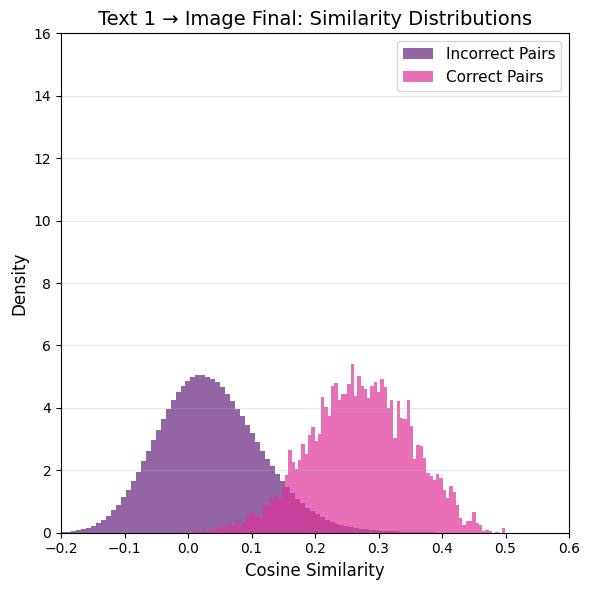

In [56]:
projected_encoder = "text"
layer = 1

correct_sims = similarities[projected_encoder][layer]["correct"]
incorrect_sims = similarities[projected_encoder][layer]["incorrect"]

# Usage:
fig = plot_similarity_distributions(
    correct_sims,
    incorrect_sims,
    projected_encoder,
    layer=layer,
    correct_color="#dd3497",
    incorrect_color="#49006a",
    bins=100
)
plt.show()

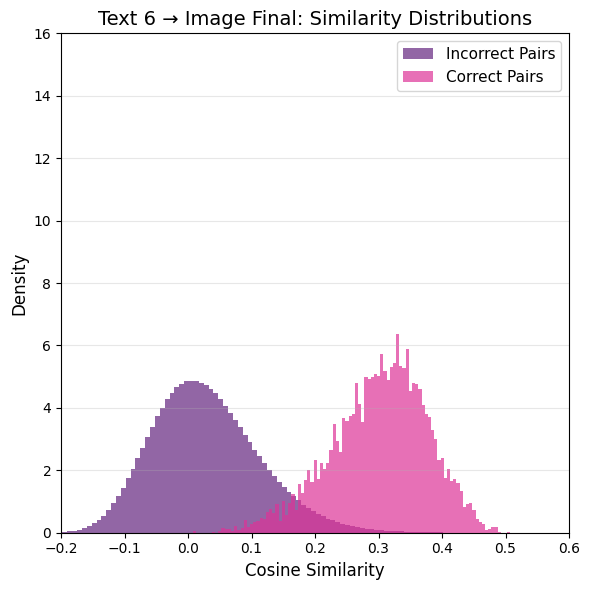

In [57]:
projected_encoder = "text"
layer = 6

correct_sims = similarities[projected_encoder][layer]["correct"]
incorrect_sims = similarities[projected_encoder][layer]["incorrect"]

# Usage:
fig = plot_similarity_distributions(
    correct_sims,
    incorrect_sims,
    projected_encoder,
    layer=layer,
    correct_color="#dd3497",
    incorrect_color="#49006a",
    bins=100
)
plt.show()

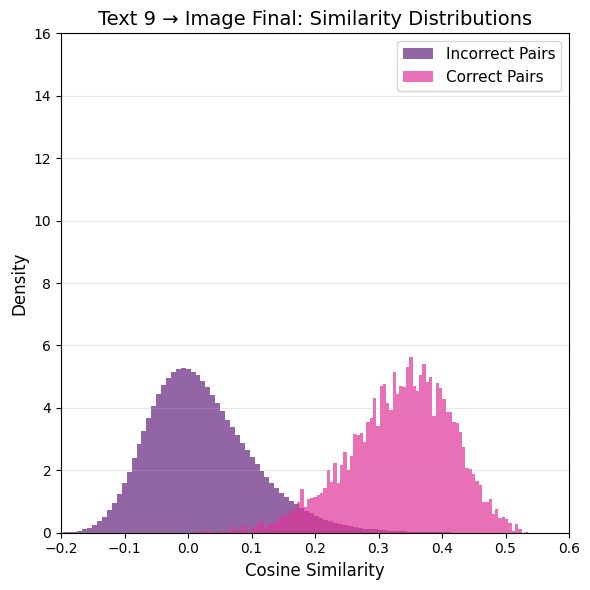

In [58]:
projected_encoder = "text"
layer = 9

correct_sims = similarities[projected_encoder][layer]["correct"]
incorrect_sims = similarities[projected_encoder][layer]["incorrect"]

# Usage:
fig = plot_similarity_distributions(
    correct_sims,
    incorrect_sims,
    projected_encoder,
    layer=layer,
    correct_color="#dd3497",
    incorrect_color="#49006a",
    bins=100
)
plt.show()

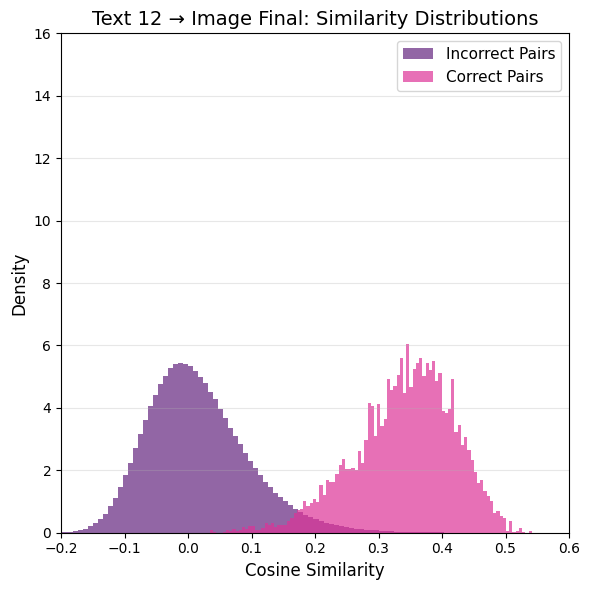

In [ ]:
projected_encoder = "text"
layer = 12

correct_sims = similarities[projected_encoder][layer]["correct"]
incorrect_sims = similarities[projected_encoder][layer]["incorrect"]

# Usage:
fig = plot_similarity_distributions(
    correct_sims,
    incorrect_sims,
    projected_encoder,
    layer=layer,
    correct_color="#dd3497",
    incorrect_color="#49006a",
    bins=100
)
plt.show()

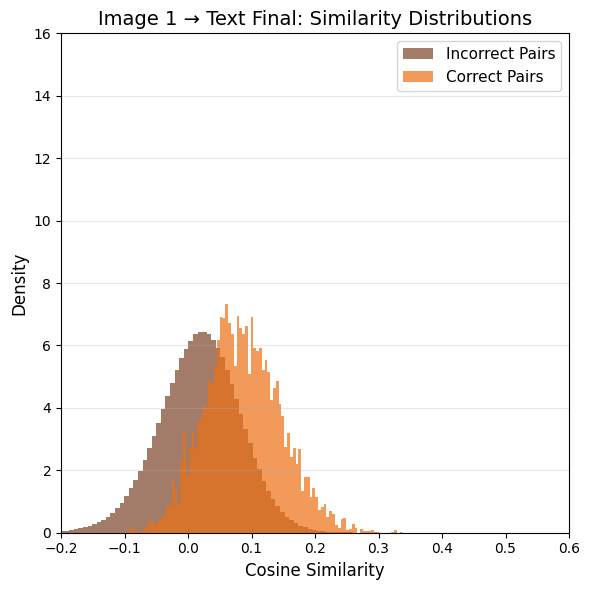

In [60]:
projected_encoder = "image"
layer = 1

correct_sims = similarities[projected_encoder][layer]["correct"]
incorrect_sims = similarities[projected_encoder][layer]["incorrect"]

# Usage:
fig = plot_similarity_distributions(
    correct_sims,
    incorrect_sims,
    projected_encoder,
    layer=layer,
    correct_color="#ec7014",
    incorrect_color="#662506",
    bins=100
)
plt.show()

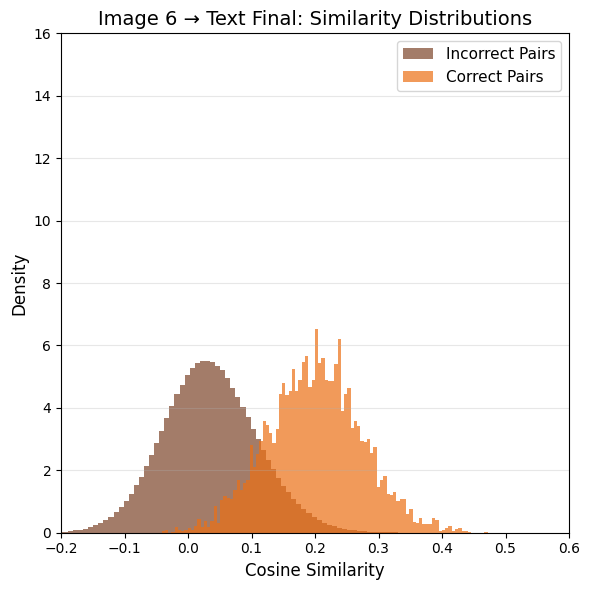

In [61]:
projected_encoder = "image"
layer = 6

correct_sims = similarities[projected_encoder][layer]["correct"]
incorrect_sims = similarities[projected_encoder][layer]["incorrect"]

# Usage:
fig = plot_similarity_distributions(
    correct_sims,
    incorrect_sims,
    projected_encoder,
    layer=layer,
    correct_color="#ec7014",
    incorrect_color="#662506",
    bins=100
)
plt.show()

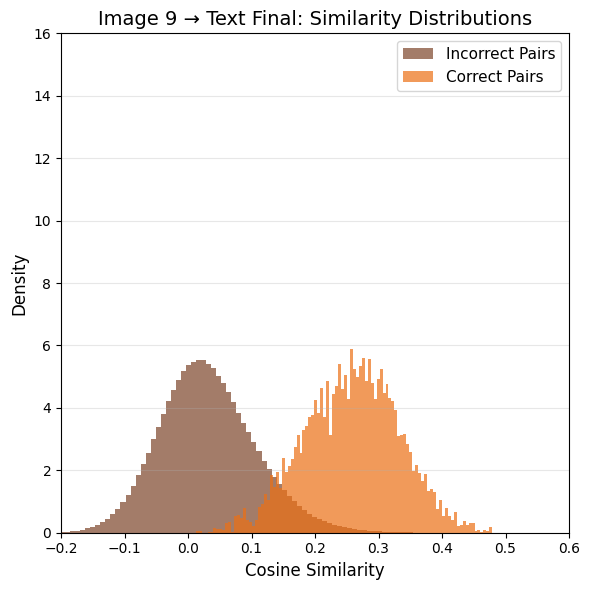

In [62]:
projected_encoder = "image"
layer = 9

correct_sims = similarities[projected_encoder][layer]["correct"]
incorrect_sims = similarities[projected_encoder][layer]["incorrect"]

# Usage:
fig = plot_similarity_distributions(
    correct_sims,
    incorrect_sims,
    projected_encoder,
    layer=layer,
    correct_color="#ec7014",
    incorrect_color="#662506",
    bins=100
)
plt.show()

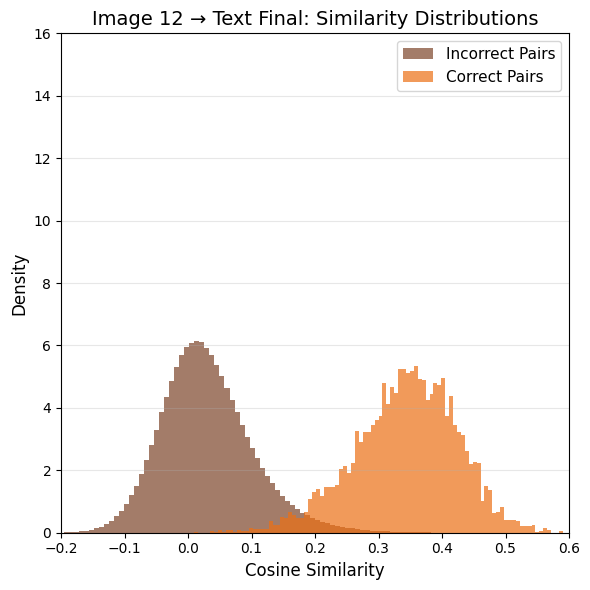

In [63]:
projected_encoder = "image"
layer = 12

correct_sims = similarities[projected_encoder][layer]["correct"]
incorrect_sims = similarities[projected_encoder][layer]["incorrect"]

# Usage:
fig = plot_similarity_distributions(
    correct_sims,
    incorrect_sims,
    projected_encoder,
    layer=layer,
    correct_color="#ec7014",
    incorrect_color="#662506",
    bins=100
)
plt.show()

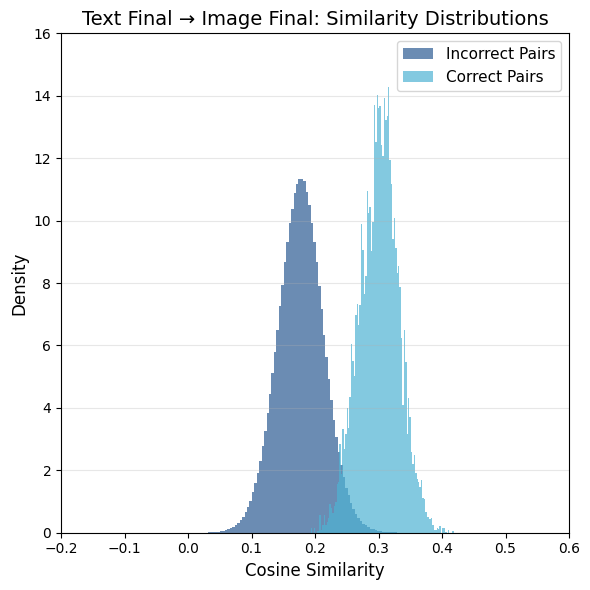

In [64]:
projected_encoder = "text"
layer = "Final"

correct_sims = pretrained_similarities["correct"]
incorrect_sims = pretrained_similarities["incorrect"]

# Usage:
fig = plot_similarity_distributions(
    correct_sims,
    incorrect_sims,
    projected_encoder,
    layer=layer,
    correct_color="#4eb3d3",
    incorrect_color="#084081",
    bins=100
)
plt.show()

In [1]:
from open_clip import CLIP